<h1>Step 1: Exploratory Data Analysis.</h1></br> This stage is the very initial stage of your
data analysis. You may want to know the size and sentiment distribution of
the dataset. You may also want to examine if there are any missing values.
This initial data analysis stage helps you to have a better understanding of the
dataset before you build your sentiment classification models.

In [1]:
import pandas as pd
train_data = pd.read_csv('data/train.csv').sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)
test_data = pd.read_csv('data/test.csv').sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)

In [2]:
train_data.head(10)
#train_data.isnull().sum()
#train_data['Sentiment'].value_counts()
#train_data['Sentiment'].plot()

,Text,Index,Sentiment
0,The worst part about laundry is: the longer th...,1838,0
1,Class at 1245 leaving early to go home. Bringi...,1024465,1
2,Just moved into con dron and locked out alread...,292850,0
3,@mollyrazor thank you that's just what I needed,948740,1
4,"http:/defaultprime.com fucking dropped 300,200...",299489,0
5,Got season 2 of Jericho today and there are on...,191757,0
6,@celebritee I wish I had it in me man.. I just...,536472,0
7,"@Bizarre57 yup, and i'll be put downstairs wit...",289425,0
8,i really can't study right now. I NEED MOTIVAT...,17191,0
9,@hollieleanne @PrincessAymi @AmyleeEdith i go ...,23680,0


<h1>Step 2: Text Preprocessing.</h1></br> You need to prepare your training and testing
dataset. Specifically for this problem, you need to preprocess the discussion
texts, you may want to convert all words into lowercase and remove digital
numbers and special characters. Please refer to our slides and class
discussions for a full list of text preprocessing steps.


In [3]:
# remove extra whitespace and convert upper to lower
train_data = train_data.convert_dtypes()
train_data['Text'] = train_data['Text'].str.strip()
train_data['Text'] = train_data['Text'].str.lower()

test_data = test_data.convert_dtypes()
test_data['Text'] = test_data['Text'].str.strip()
test_data['Text'] = test_data['Text'].str.lower()

In [4]:
# remove special characters
import re
# regex removes urls, user mentions and special characters respectively
regex_pattern = re.compile('(http)[\S]* ?|(@)[\S]* ?|[^A-Z^a-z ]', flags=re.IGNORECASE)
train_data['Text'] = train_data['Text'].str.replace(regex_pattern, '', regex=True)
train_data['Text'] = train_data['Text'].str.split()

test_data['Text'] = test_data['Text'].str.replace(regex_pattern, '', regex=True)
test_data['Text'] = test_data['Text'].str.split()

In [5]:
# remove stop words and stemming
# (based on research, stemming seems like a better choice for sentiment analysis rather than lemmatization)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# removing and stemming in one pass takes about 3 minutes
train_data['Text'] = train_data['Text'].apply(lambda text : [stemmer.stem(word) for word in text if not word in english_stopwords])
test_data['Text'] = test_data['Text'].apply(lambda text : [stemmer.stem(word) for word in text if not word in english_stopwords])


train_data.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\twinb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Text,Index,Sentiment
0,"[worst, part, laundri, longer, wait, unpleas, ...",1838,0
1,"[class, leav, earli, go, home, bring, lauren]",1024465,1
2,"[move, con, dron, lock, alreadi, miss, friend]",292850,0
3,"[thank, that, need]",948740,1
4,"[fuck, drop, spot, technoraticom, sad, panda]",299489,0
5,"[got, season, jericho, today, seven, episod, m...",191757,0
6,"[wish, man, couldnt, suck, cuz, realli, like, ...",536472,0
7,"[yup, ill, put, downstair, signal, ii, wont, a...",289425,0
8,"[realli, cant, studi, right, need, motiv, caus...",17191,0
9,"[go, away, clean, hous, dish, come, back, call...",23680,0


<h1>Step 3: Linguistic Feature Extraction.</h1></br> You will extract linguistic features
from the processed texts. You may consider a wide range of features we
covered in the class, including bag-of-words, tf*idf, word2vec, etc. You may
also consider other word-embedding semantic features such as Glove or
BERT, but these are not required.


In [6]:
# extract the 5,000 most frequent words from a set of roughly 250,000 unique words
import itertools

# create a dictionary of all words with counts of 0
corpus = dict.fromkeys(set(itertools.chain.from_iterable(train_data.Text)), 0)
for word in itertools.chain.from_iterable(train_data.Text):
    corpus[word] = corpus[word] + 1
    
d = dict(sorted(corpus.items(), key=lambda item: item[1], reverse=True))

new_dict = {}
index = 0
for key, val in d.items():
    if (index >= 1000):
        break
    index = index + 1
    new_dict[key] = d[key]

In [7]:
# Bag-of-Words Feature Extraction: Takes roughly 30 seconds

# initialize array to hold counts for each sentence
arr = []
keys = new_dict.keys()
# loop through 10% of the data due to time constraints
# create frequency counts for each key word in each sentence
for i in range(50000):
    test = dict.fromkeys(keys, 0)
    for word in train_data.at[i, 'Text']:
        if (word in keys):
            test[word] = test[word] + 1
    arr.append(test)

# initialize bag of words dataframe
bow_df = pd.DataFrame.from_dict(arr)

In [8]:
# TF*IDF Feature Extraction: Takes roughly 1 minute 30 seconds
import math

# Term frequency:
# N (word)/N (total words in this sentence)
tf_arr = []

# loop through 5% of the data due to time constraints
# create term frequency dicts for each sentence and store them all in one array
for i in range(50000):
    word_list = train_data.at[i, 'Text']
    tf_dict = {}
    wordCount = len(word_list)
    if wordCount == 0:
        continue
    word_freq = dict.fromkeys(keys, 0)
    for word in word_list:
        if word_freq.get(word, -1) != -1:
            word_freq[word] += 1
    for word, count in word_freq.items():
            tf_dict[word] = count / wordCount
    tf_arr.append(tf_dict)

# Inverse document frequency:
# log10 (N (sentences in the dataset)/N (sentences that contains the word)
# initalize variables for later use
n = len(train_data.index)
idf_dict = dict.fromkeys(keys, 0)

# determine the number of sentences that have a certain word in it
for arr_dict in arr:
    for word, count in arr_dict.items():
        if int(count) > 0:
            idf_dict[word] += 1
# using the previously determined value,
# divide the total number of sentences by the number of sentences containing the certain word        
for word, count in idf_dict.items():
    if count == 0:
        idf_dict[word] = math.log(n)
    else:
        idf_dict[word] = math.log(n/float(count))

# having just found the idf, multiply that against the tf for each sentence
tf_idf_arr = []
index = 0
for arr_dict in arr:
    tf_idf_dict = {}
    for word, count in arr_dict.items():
        tf_idf_dict[word] = count * idf_dict[word]
    tf_idf_arr.append(tf_idf_dict)
    
# initialize tf_idf dataframe
tf_idf_df = pd.DataFrame.from_dict(tf_idf_arr)

In [9]:
# Word2Vect Feature Extraction: Takes roughly 30 seconds
from gensim.models import Word2Vec
model = Word2Vec(sentences=train_data.Text, vector_size=100, window=5, min_count=1, workers=4)
wv = model.wv

wv_arr = []
for i in range(50000):
    wv_arr.append(wv[i])

wv_df = pd.DataFrame(wv_arr)

<h1>Step 4: Build your sentiment classification model.</h1></br> Provide the extracted
set of linguistic features from the training dataset to your classification model.
Note that this is a binary classification problem. You may want to start with
classical machine learning algorithms such as Logistic Regression, SVM, Naive
Bayes, and Random Forest. You may also consider neural-network-based
classifiers, such as multilayer perceptron, but these are not required.


In [10]:
# Import popular libraries to utilize later
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

In [12]:
new_bow_df = train_data.merge(bow_df, how="right", left_index=True, right_index=True).drop('Index', axis=1).drop('Text', axis=1)
new_tfidf_df = train_data.merge(tf_idf_df, how="right", left_index=True, right_index=True).drop('Index', axis=1).drop('Text', axis=1)
new_wv_df = train_data.merge(wv_df, how="right", left_index=True, right_index=True).drop('Index', axis=1).drop('Text', axis=1)

# dependent and independent values
y_bow = new_bow_df['Sentiment'].to_numpy()
X_bow = new_bow_df.drop('Sentiment',axis=1).to_numpy()
y_tfidf = new_tfidf_df['Sentiment'].to_numpy()
X_tfidf = new_tfidf_df.drop('Sentiment',axis=1).to_numpy()
y_wv = new_wv_df['Sentiment'].to_numpy()
X_wv = new_wv_df.drop('Sentiment',axis=1).to_numpy()

scale = StandardScaler()
scaled_X_bow = scale.fit_transform(X_bow)
scaled_X_tfidf = scale.fit_transform(X_tfidf)
scaled_X_wv = scale.fit_transform(X_wv)

X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(scaled_X_bow, y_bow, test_size = 0.2)
y_bow_train = y_bow_train.astype('int')
X_bow_train = X_bow_train.astype('int')
y_bow_test = y_bow_test.astype('int')
X_bow_test = X_bow_test.astype('int')

X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(scaled_X_tfidf, y_tfidf, test_size = 0.2)
y_tfidf_train = y_tfidf_train.astype('int')
X_tfidf_train = X_tfidf_train.astype('int')
y_tfidf_test = y_tfidf_test.astype('int')
X_tfidf_test = X_tfidf_test.astype('int')

X_wv_train, X_wv_test, y_wv_train, y_wv_test = train_test_split(scaled_X_wv, y_wv, test_size = 0.2)
y_wv_train = y_wv_train.astype('int')
X_wv_train = X_wv_train.astype('int')
y_wv_test = y_wv_test.astype('int')
X_wv_test = X_wv_test.astype('int')

In [19]:
# Logistic Regression model. Almost instant
lc_bow = LogisticRegression(max_iter=500)
lc_tfidf = LogisticRegression(max_iter=500)
lc_wv = LogisticRegression(max_iter=500)

lc_bow.fit(X_bow_train, y_bow_train)
lc_tfidf.fit(X_tfidf_train, y_tfidf_train)
lc_wv.fit(X_wv_train, y_wv_train)

y_lc_bow_predicted = lc_bow.predict(X_bow_test).astype('int')
y_lc_bow_pred_proba = lc_bow.predict_proba(X_bow_test).astype('int')
y_lc_tfidf_predicted = lc_tfidf.predict(X_tfidf_test).astype('int')
y_lc_tfidf_pred_proba = lc_tfidf.predict_proba(X_tfidf_test).astype('int')
y_lc_wv_predicted = lc_wv.predict(X_wv_test).astype('int')
y_lc_wv_pred_proba = lc_wv.predict_proba(X_wv_test).astype('int')

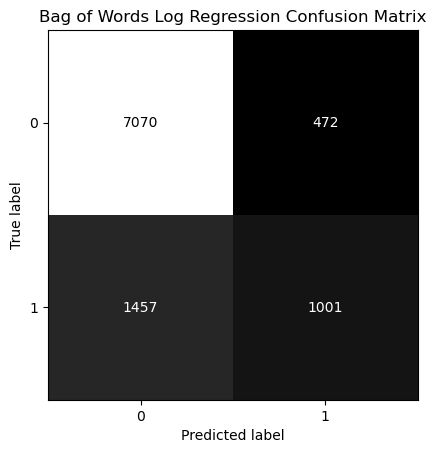

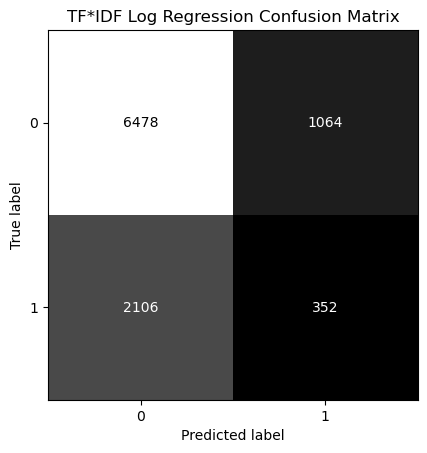

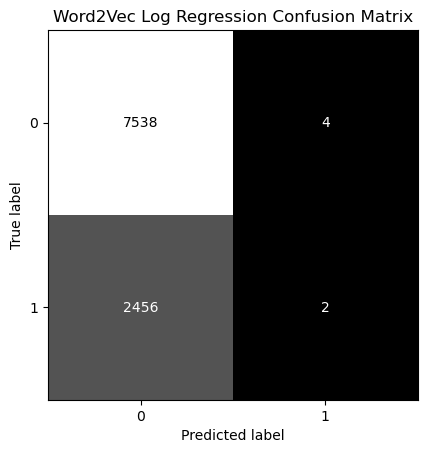

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7542
           1       0.68      0.41      0.51      2458

    accuracy                           0.81     10000
   macro avg       0.75      0.67      0.69     10000
weighted avg       0.79      0.81      0.79     10000

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7604
           1       0.66      0.39      0.49      2396

    accuracy                           0.81     10000
   macro avg       0.74      0.66      0.68     10000
weighted avg       0.79      0.81      0.79     10000

              precision    recall  f1-score   support

           0       0.76      1.00      0.87      7628
           1       0.17      0.00      0.00      2372

    accuracy                           0.76     10000
   macro avg       0.46      0.50      0.43     10000
weighted avg       0.62      0.76      0.66     10000



In [25]:
models = ['Bag of Words Log Regression', 'TF*IDF Log Regression', 'Word2Vec Log Regression']
predictions = [y_lc_bow_predicted, y_lc_tfidf_predicted, y_lc_wv_predicted]
pred_probabilities = [y_lc_bow_pred_proba, y_lc_tfidf_pred_proba, y_lc_wv_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_bow_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")
plt.show()

print(classification_report(y_bow_test, y_lc_bow_predicted))
print(classification_report(y_tfidf_test, y_lc_tfidf_predicted))
print(classification_report(y_wv_test, y_lc_wv_predicted))

In [ ]:
# Support Vector Classifier. Takes 
svc = SVC(probability=True)

svc.fit(X_bow_train, y_bow_train)

y_svc_predicted = svc.predict(X_bow_test)
y_svc_pred_proba = svc.predict_proba(X_bow_test)

print(classification_report(y_bow_test, y_svc_predicted))

In [ ]:
nbc = GaussianNB()

nbc.fit(X_train, y_train)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

print(classification_report(y_bow_test, y_nbc_predicted))

In [ ]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

print(classification_report(y_bow_test, y_rfc_predicted))

<h1>Step 5: Model evaluation.</h1></br> Evaluate your model performance with the
provided testing dataset. Recall the evaluation metrics we covered in the class
and select appropriate metrics for this problem. Please compare the
performance of different classifiers using the same linguistic feature and the
performance of the same classifier using different linguistic features. Finally,
discuss your experimental results and submit the assignment report.

In [ ]:
models = ['Logistic Regression','Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_lc_bow_predicted, y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_lc_bow_pred_proba, y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()